**Описание задания**   
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

**Описание колонок**  
experimentVariant – вариант эксперимента  
version – версия приложения  
purchase – факт покупки  

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [6]:
df=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-na-t/lesson_10/hw_aa.csv', sep=';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


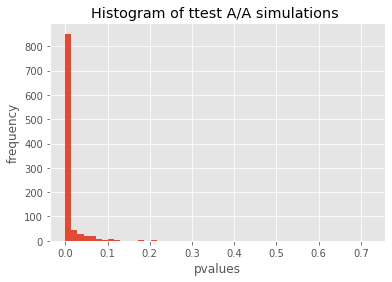

0.939

In [8]:
n = 100000
simulations = 1000
n_s = 1000
res = []

##df = pd.DataFrame({
#    "s1": np.random.exponential(scale=1/0.001, size=n),
#    "s2": np.random.exponential(scale=1/0.001, size=n)
#})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [27]:
0.939 < 0.05

False

АА тест не сходится: сплит-система сломана. Проанализируем данные, чтобы понять где ошибка.

In [26]:
df.groupby(['experimentVariant', 'version']).agg({'purchase':'mean', 'uid':'count'})

purchase    uid
experimentVariant version                  
0                 v2.8.0    0.000993  41283
                  v2.9.0    0.074658  11921
                  v3.7.4.0  0.059943   4204
                  v3.8.0.0  0.057604   5694
1                 v2.8.0    0.045606  41552
                  v2.9.0    0.071304  12033
                  v3.7.4.0  0.063018   4221
                  v3.8.0.0  0.062848   6110

Среднее значение конверсии в покупку(СR) у пользователей версии v2.8.0 в 0 варианте примерно в 40 раз ниже чем в 1 варианте эксперимента. Это говорит о наличии проблемы в версиии v2.8.0 мобильного приложения.  
Исключим данные по этой группе пользователей из экспериимента.

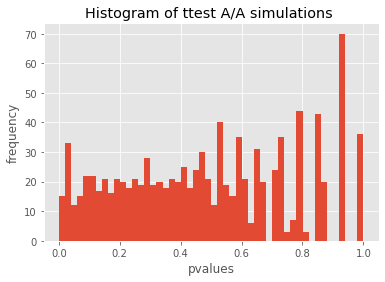

0.054

In [29]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

AA тест сошелся. Мы доказали, что проблема была в группе данных по версии приложения v2.8.0.